Here we are going to use the American Community Survey 5 year estimates from 2017. I got this data from https://factfinder.census.gov/faces/tableservices/jsf/pages/productview.xhtml?pid=ACS_17_5YR_DP05&prodType=table

A few notes about the census tracts @ https://www.easidemographics.com/trshelp/html/census_tract_2.htm:

We currently only have demographic data to the census tract level. To get a rough estimate of the distribution of people within those census tracks I am randomly distributing the number of people within each tract and recording those x- and y-coordinates. In the future we might make this more accurate, but for now this will work for testing.

In [42]:
# import libraries
import pandas as pd
import numpy as np
import shapefile as shp
import matplotlib.pyplot as plt
import seaborn as sns
import random
from shapely.geometry import Polygon, Point
from shapely.wkb import loads
from collections import defaultdict
import geopy.distance

In [2]:
# load ACS file
from ipynb.fs.full.demog_functions import clean_data

demog_data = clean_data('ACS_17_5YR_B02001/ACS_17_5YR_B02001_with_ann.csv')
demog_data.head()

//anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4025: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  return super(DataFrame, self).rename(**kwargs)
ipynb.fs.full.demog_functions:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
ipynb.fs.full.demog_functions:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
ipynb.fs.full.demog_functions:51: SettingWithCopyWarning: 
A

,GEO_display_label,total_pop,tot_whites,tot_blacks,tot_natives,tot_asians,tot_hawaiians,tot_other,tot_twoplus,census_tract,boro
1,"Census Tract 1, Bronx County, New York",7411,1464,4509,22,125,0,1201,90,Census Tract 1,Bronx County
2,"Census Tract 2, Bronx County, New York",5058,2665,1233,0,158,0,742,260,Census Tract 2,Bronx County
3,"Census Tract 4, Bronx County, New York",5944,2616,1962,30,54,0,1085,197,Census Tract 4,Bronx County
4,"Census Tract 16, Bronx County, New York",6115,2685,2320,0,11,0,989,110,Census Tract 16,Bronx County
5,"Census Tract 19, Bronx County, New York",2817,519,1054,0,78,0,1049,117,Census Tract 19,Bronx County


In [3]:
# create a dict converting the boro name to number for future reference
boro_conversion = {'Bronx County' : '005',
             'Kings County' : '047',
             'New York County' : '061',
             'Queens County' : '081',
             'Richmond County' : '085'}

Now we generate some synthetic data. Because the census data is only to the census-tract level, the best way to model the distribution of the population within each tract for now is to randomly distribute the 'population' within the polygon defining the tract.

In [4]:
# turn the shapefile polygons into shapely polygons

# connect to shapefile downloaded from NYU's GIS resources.
shp_path = 'nyu_2451_34513/nyu_2451_34513.shp' 
sf = shp.Reader(shp_path) # 'sf' refers to the extracted shape data

In [5]:
# convert the shape files to dataframe.
# this will help us to connect it to the ACS data
from ipynb.fs.full.demog_functions import read_shapefile

shapedf = read_shapefile(sf)
shapedf.head()

,statefp,countyfp,tractce,geoid,name,namelsad,mtfcc,funcstat,aland,awater,intptlat,intptlon,coords
0,36,005,000100,36005000100,1,Census Tract 1,G5020,S,1579361,1125765,+40.7934921,-073.8835318,"[(1012569.2511336459, 228983.70178121014), (10..."
1,36,005,000200,36005000200,2,Census Tract 2,G5020,S,455322,926899,+40.8045733,-073.8568585,"[(1021558.2468548007, 236060.6961875496), (102..."
2,36,005,000400,36005000400,4,Census Tract 4,G5020,S,912392,602945,+40.8089152,-073.8504884,"[(1023113.7226130426, 236337.84900077982), (10..."
3,36,005,001600,36005001600,16,Census Tract 16,G5020,S,485079,0,+40.8188478,-073.8580764,"[(1022690.1479616419, 238650.34629134185), (10..."
4,36,005,001900,36005001900,19,Census Tract 19,G5020,S,1643654,1139660,+40.8009990,-073.9093729,"[(1003183.625868493, 233654.4443848743), (1003..."


In [6]:
# use these lists to loop through the unique tracts X boros to generate random locations
temp = demog_data[['census_tract','boro']].drop_duplicates()

census_list = temp['census_tract']
boro_list = temp['boro']

In [7]:
# This starts to build out the structure of the table to store the data for each individuals' race + set of points
data = {}
county_list = ['Bronx County','Kings County','New York County','Queens County','Richmond County']

for county in county_list:
    census_tract_list = census_list[boro_list==county]
    data[county]={}
    for tract in census_tract_list:
        data[county][tract] = {}

In [8]:
# want to store the generate data points in a structure where the 1st level = boro, 2nd level = census tract, 3rd level = generated data including the race + randomly generated lat & long dimensions.
from ipynb.fs.full.demog_functions import generate_people,random_points_within

# generate random points within that polygon
#from ipynb.fs.full.demog_functions import random_points_within
df = []
for tract_num,boro_name in zip(census_list,boro_list):
    synth_data = generate_people(shapedf, demog_data, boro_name, tract_num)
    coordinates = synth_data[0]
    population = synth_data[1]
    races = synth_data[2]

    polygon = Polygon(coordinates)
    points = random_points_within(polygon,population)    
    
    # initiate a list to store the new points
    point_x = []
    point_y = []
    
    for p in points:
        point_x.append(p.x)
        point_y.append(p.y)
    
    # insert into table df for clustering
    record = list(zip(races, point_x, point_y))
    
    # initialize a list for list of lists
    lirow = []
    
    for row in record:
        row = list(row)
        lirow.append(row)
        
    df.extend(lirow)
    
df = pd.DataFrame(df, columns = ['race','xcoords','ycoords'])


,race,xcoords,ycoords
0,white,1.017473e+06,228551.726460
1,white,1.019718e+06,228670.764064
2,black,1.017561e+06,226701.883265
3,white,1.019595e+06,228213.028587
4,black,1.015539e+06,228631.265192
5,white,1.017735e+06,226749.117670
6,black,1.017146e+06,226649.508042
7,black,1.015561e+06,229742.759943
8,white,1.016505e+06,228522.803755
9,black,1.013096e+06,228983.490400


In [9]:
# write dataframe to file
#df.to_csv(r'PseudoSynthDemogData.csv',index = None,header=True)

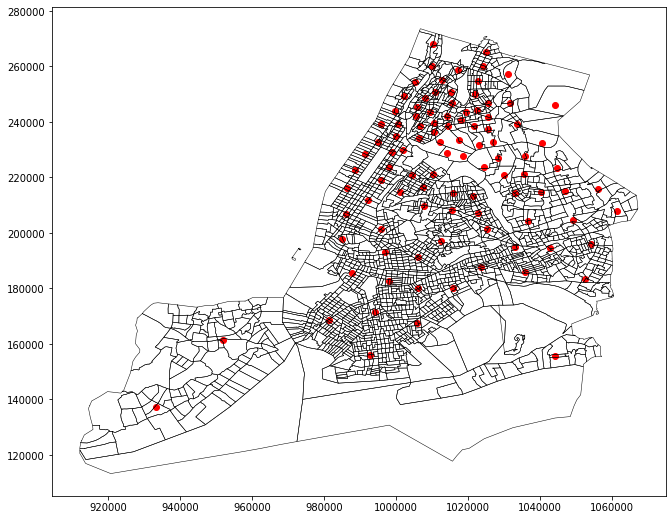

In [39]:
# plot kmeans as a sanity check
from ipynb.fs.full.demog_functions import plot_shape, plot_map

centroids = pd.read_csv('kmeans_centroids/k_100.csv',header=None,names=['x','y'],index_col=False)

plot_map(sf)
plt.scatter(centroids.x,centroids.y,color='r')

In [ ]:
#tract = 'Census Tract 4'
#boro = boro_conversion['Bronx County']
#com_id = shapedf[(shapedf.countyfp==boro) & (shapedf.namelsad == tract)].index.get_values()[0]

#plot_shape(com_id,shp.Reader(shp_path),tract)
#sns.scatterplot(point_x,point_y,hue=races)   

In [40]:
#sns.scatterplot(df.xcoords,df.ycoords,hue=df.race,size=0.5,markers='.')